# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/github/WilliamJWen/APS360/blob/main/lab/Lab4_Data_Imputation.ipynb

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [38]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-38-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [39]:
original_df = df.copy() # save a copy of the original data frame
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [40]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [41]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [42]:
df["age"] = df["age"] + 1
df[:3]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,40,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,51,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,39,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [43]:
df["age"] = df["age"] - 1

In [57]:
max_values = subdf.max()
min_values = subdf.min()

In [58]:
print(max_values)
print(min_values)

age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64
age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64


In [45]:
# Normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1
df[["age", "yredu", "capgain", "caploss", "workhr"]] = (subdf - subdf.min())/(subdf.max() - subdf.min())
df[:3]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [44]:
# hint: you can do something like this in pandas
num_male = sum(df["sex"] == " Male")
num_female = sum(df["sex"] == " Female")
num_people = len(df)
print(num_male, num_female, num_people)
print(f'{(num_female/num_people * 100):.2f}% of people in out data set are female')

21790 10771 32561
33.08% of people in out data set are female


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [48]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [13]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [14]:
print(f'{(len(df_with_missing)/len(df) * 100):.2f}% of records were removed')
print(f'{len(df_with_missing)} records were removed')

5.66% of records were removed
1843 records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [15]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [16]:
data = pd.get_dummies(df_not_missing)

In [17]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [18]:
len(data.columns)

57

Answer: There are **57** columns in the dataframe `data` from the code above. The process from `get_dummies` has performed one-hot encoding processing for cateforical features like `work`, turning that one column into multiple binary columns representing different categories and keep the Continuos Features intact.



### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [19]:
datanp = data.values.astype(np.float32)

In [20]:
print(datanp.shape)
print(datanp[:3])

(30718, 57)
[[0.30136988 0.8        0.02174022 0.         0.39795917 0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         1.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         1.        ]
 [0.4520548  0.8        0.         0.         0.12244898 0.
  0.         0.         0.         1.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.    

In [21]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

Unit Testing for `get_categorical_value`:

In [22]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [23]:
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [24]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [25]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
train_size = int(0.7 * len(datanp))
valid_size = int(0.15 * len(datanp))
test_size = len(datanp) - train_size - valid_size
train_data, valid_data, test_data = torch.utils.data.random_split(datanp, [train_size, valid_size, test_size])


In [26]:
print(f'Training set size: {len(train_data)}')
print(f'Validation set size: {len(valid_data)}')
print(f'Test set size: {len(test_data)}')

Training set size: 21502
Validation set size: 4607
Test set size: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [27]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(40, 25),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(40, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**Answer:** Sigmoid in the last step ensures the output is in the range of 0 and 1. This is because we have normalized our data to the range of 0 and 1.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [28]:
import time
import matplotlib.pyplot as plt

In [29]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_data, valid_data, batch_size=64, num_epochs=5, learning_rate=1e-4, plotting=True):
    """ Training loop. You should update this."""
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False) # no shuffle to ensure consistency

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    for epoch in range(num_epochs):

        # Training Phase
        model.train()
        total_train_loss = 0.0

        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += train_loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss) # compute *average* loss

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        # Validation Phase
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
          for data in val_loader:
              datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
              recon = model(datam)
              loss = criterion(recon, data)
              total_val_loss += loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        # compute accuracy
        train_acc.append(get_accuracy(model, train_loader))  # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))    #compute validation accuracy

        epochs.append(epoch + 1)

        if plotting:
          print(f"Epoch {epoch + 1}: Train Acc: {train_acc[-1]:.4f} | Train Loss: {train_losses[-1]:.4f} | "
                f"Validation Acc: {val_acc[-1]:.4f} | Validation Loss: {val_losses[-1]:.4f}")

    print("Finish Training")
    elapsed_time = time.time() - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    if plotting:
      # plot loss curve
      plt.title("Training Loss Curve")
      plt.plot(epochs, train_losses, label="Train")
      plt.plot(epochs, val_losses, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

      # Plot Accuracy Curve
      plt.title("Training Accuracy Curve")
      plt.plot(epochs, train_acc, label="Train")
      plt.plot(epochs, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()

    print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                  epoch)
    return path



### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [30]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train Acc: 0.4214 | Train Loss: 0.2075 | Validation Acc: 0.4200 | Validation Loss: 0.1256
Epoch 2: Train Acc: 0.4599 | Train Loss: 0.0809 | Validation Acc: 0.4594 | Validation Loss: 0.0717
Epoch 3: Train Acc: 0.4604 | Train Loss: 0.0709 | Validation Acc: 0.4588 | Validation Loss: 0.0707
Epoch 4: Train Acc: 0.4593 | Train Loss: 0.0701 | Validation Acc: 0.4576 | Validation Loss: 0.0699
Epoch 5: Train Acc: 0.4604 | Train Loss: 0.0689 | Validation Acc: 0.4579 | Validation Loss: 0.0680
Epoch 6: Train Acc: 0.5124 | Train Loss: 0.0649 | Validation Acc: 0.5108 | Validation Loss: 0.0615
Epoch 7: Train Acc: 0.5225 | Train Loss: 0.0583 | Validation Acc: 0.5226 | Validation Loss: 0.0564
Epoch 8: Train Acc: 0.5391 | Train Loss: 0.0553 | Validation Acc: 0.5398 | Validation Loss: 0.0545
Epoch 9: Train Acc: 0.5585 | Train Loss: 0.0536 | Validation Acc: 0.5550 | Validation Loss: 0.0527
Epoch 10: Train Acc: 0.5682 | Train Loss: 0.0516 | Validation Acc: 0.5656 | Validation Loss: 0.0508
Epoch 11:

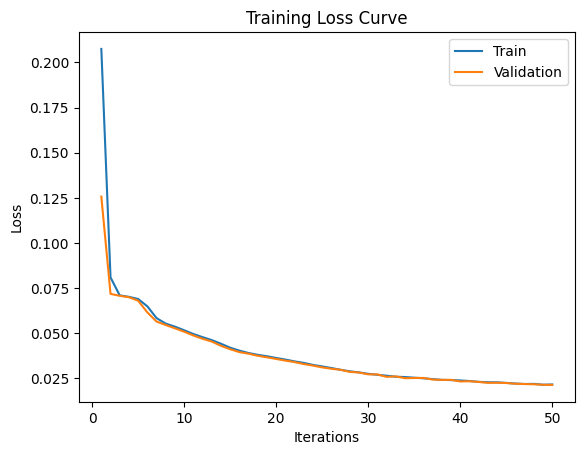

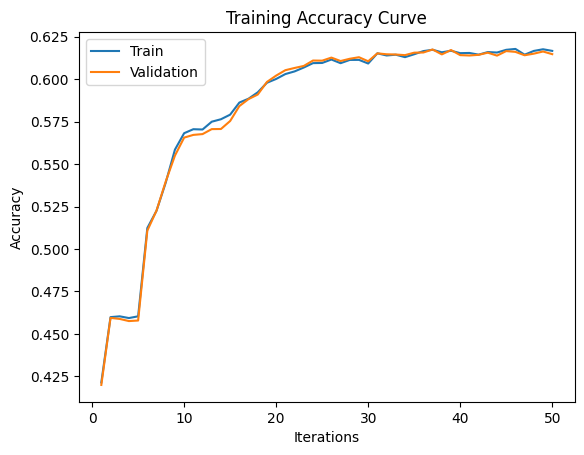

Final Training Accuracy: 0.6166
Final Training Loss: 0.0216
Final Validation Accuracy: 0.6147
Final Validation Loss: 0.0213


In [34]:
model = AutoEncoder()
train(model, train_data, valid_data, batch_size=64, num_epochs=50, learning_rate=1e-4)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

**Answer**: The model showed good trends of a steadily increasing accuracy and decreasing loss, without any sign of overfitting, but starts to enter a plateau, and ened up with 0.6147 Validation Accuracy.
- So I first increased the batach size in the hope to speed up training, but the performance went down slightly, but basicaly is the same.
- The second time, I decreased the batch_size, and the accuracy increased slightly to 0.6301.
- The third time, I tried to increase model complexity by adding another layer, but this didn't solve the plataeu issue, and the validation accuracy is slightly worse at 0.6106.  
- The fourth time I tried to have the first layer of my model to be an expansion layer, having more neurons than the input neuron, this did not help the performance, ended in 0.6044 Validation Accuracy, and the model still enters a plateau.  
- The fifth time, I tried to widen my hidden space, this did not help.
- The sixth time, I used the current best performing hyperaparameter, which is step 2, with original model and batch_size=32, I decreased learning rate to 1e-5, this worsen the validation Accuracy to 0.6036.
- The seventh time, I did the other way around, increasing learning rate to 1e-3, this significantly increased validation Accuracy to 0.6649 and decrease Validation Loss to 0.0103. I think the increase in learning rate helped my model to evade local minimum.
- ... After tuning around the seventh time hyperparameter, My model's performance ended up with 0.7156 Validation Accuracy, 0.0084 Validation Loss, on batch_size=64, learning_rate=3e-3, epoch=44.

In [32]:
# 1.increase batch size
model = AutoEncoder()
train(model, train_data, valid_data, batch_size=128, num_epochs=50, learning_rate=1e-4, plotting=False)

Finish Training
Total time elapsed: 126.61 seconds
Final Training Accuracy: 0.6162
Final Training Loss: 0.0273
Final Validation Accuracy: 0.6132
Final Validation Loss: 0.0276


In [33]:
# 2.decrease batch size
model = AutoEncoder()
train(model, train_data, valid_data, batch_size=32, num_epochs=50, learning_rate=1e-4, plotting=False)

Finish Training
Total time elapsed: 252.00 seconds
Final Training Accuracy: 0.6320
Final Training Loss: 0.0162
Final Validation Accuracy: 0.6301
Final Validation Loss: 0.0162


In [41]:
# 3.increase model complexity
class ComplexAutoEncoder(nn.Module):
    def __init__(self):
        super(ComplexAutoEncoder, self).__init__()
        self.name = "ComplexAutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 50), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 25),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 30), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 50),
            nn.ReLU(),
            nn.Linear(50, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch 1: Train Acc: 0.4605 | Train Loss: 0.1308 | Validation Acc: 0.4587 | Validation Loss: 0.0709
Epoch 2: Train Acc: 0.4532 | Train Loss: 0.0698 | Validation Acc: 0.4518 | Validation Loss: 0.0686
Epoch 3: Train Acc: 0.5444 | Train Loss: 0.0644 | Validation Acc: 0.5459 | Validation Loss: 0.0583
Epoch 4: Train Acc: 0.5641 | Train Loss: 0.0561 | Validation Acc: 0.5674 | Validation Loss: 0.0545
Epoch 5: Train Acc: 0.5718 | Train Loss: 0.0540 | Validation Acc: 0.5733 | Validation Loss: 0.0535
Epoch 6: Train Acc: 0.5780 | Train Loss: 0.0530 | Validation Acc: 0.5794 | Validation Loss: 0.0527
Epoch 7: Train Acc: 0.5801 | Train Loss: 0.0521 | Validation Acc: 0.5799 | Validation Loss: 0.0516
Epoch 8: Train Acc: 0.5807 | Train Loss: 0.0511 | Validation Acc: 0.5809 | Validation Loss: 0.0508
Epoch 9: Train Acc: 0.5839 | Train Loss: 0.0503 | Validation Acc: 0.5832 | Validation Loss: 0.0499
Epoch 10: Train Acc: 0.5845 | Train Loss: 0.0496 | Validation Acc: 0.5837 | Validation Loss: 0.0496
Epoch 11:

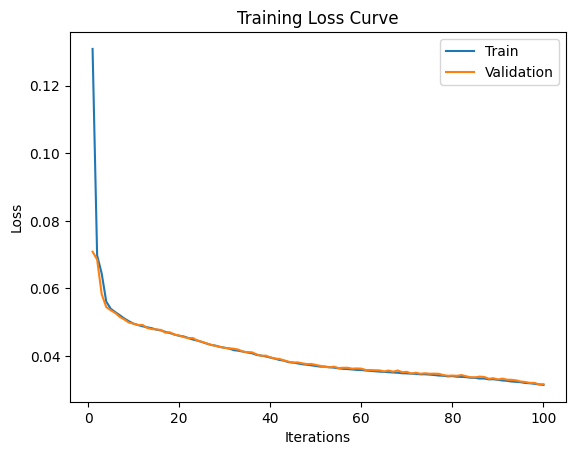

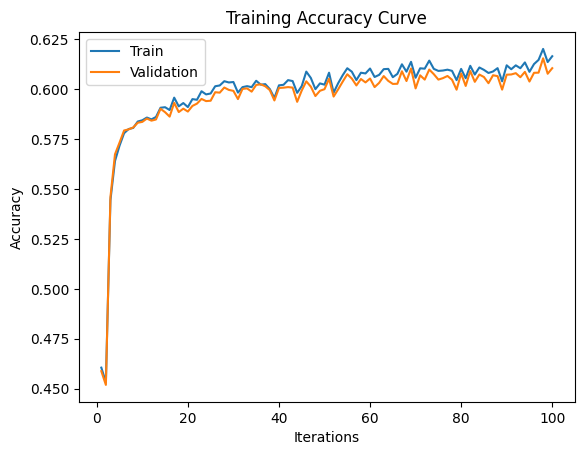

Final Training Accuracy: 0.6166
Final Training Loss: 0.0315
Final Validation Accuracy: 0.6106
Final Validation Loss: 0.0317


In [42]:
model = ComplexAutoEncoder()
train(model, train_data, valid_data, batch_size=32, num_epochs=100, learning_rate=1e-4, plotting=True)

In [43]:
# 4. increase hidden layer size first then decrease
class UpscaleAutoEncoder(nn.Module):
    def __init__(self):
        super(UpscaleAutoEncoder, self).__init__()
        self.name = "UpscaleAutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 62), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(62, 43),
            nn.ReLU(),
            nn.Linear(43, 30),
            nn.ReLU(),
            nn.Linear(30, 25),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 30), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(30, 43),
            nn.ReLU(),
            nn.Linear(43, 62),
            nn.ReLU(),
            nn.Linear(62, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch 1: Train Acc: 0.4605 | Train Loss: 0.1240 | Validation Acc: 0.4587 | Validation Loss: 0.0707
Epoch 2: Train Acc: 0.4662 | Train Loss: 0.0696 | Validation Acc: 0.4665 | Validation Loss: 0.0677
Epoch 3: Train Acc: 0.5560 | Train Loss: 0.0596 | Validation Acc: 0.5589 | Validation Loss: 0.0553
Epoch 4: Train Acc: 0.5714 | Train Loss: 0.0539 | Validation Acc: 0.5700 | Validation Loss: 0.0529
Epoch 5: Train Acc: 0.5753 | Train Loss: 0.0520 | Validation Acc: 0.5734 | Validation Loss: 0.0516
Epoch 6: Train Acc: 0.5737 | Train Loss: 0.0507 | Validation Acc: 0.5735 | Validation Loss: 0.0506
Epoch 7: Train Acc: 0.5785 | Train Loss: 0.0498 | Validation Acc: 0.5801 | Validation Loss: 0.0495
Epoch 8: Train Acc: 0.5821 | Train Loss: 0.0490 | Validation Acc: 0.5820 | Validation Loss: 0.0489
Epoch 9: Train Acc: 0.5835 | Train Loss: 0.0485 | Validation Acc: 0.5834 | Validation Loss: 0.0488
Epoch 10: Train Acc: 0.5840 | Train Loss: 0.0481 | Validation Acc: 0.5820 | Validation Loss: 0.0477
Epoch 11:

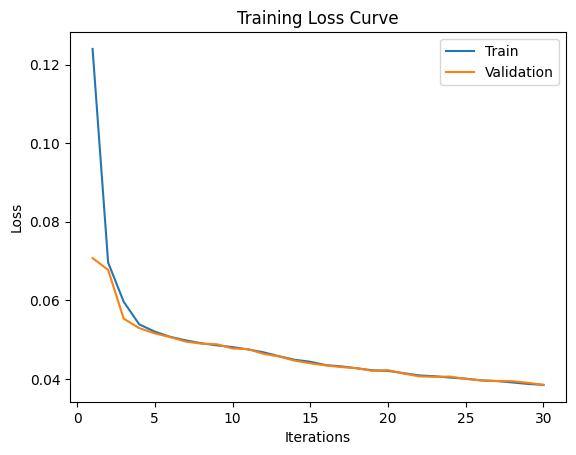

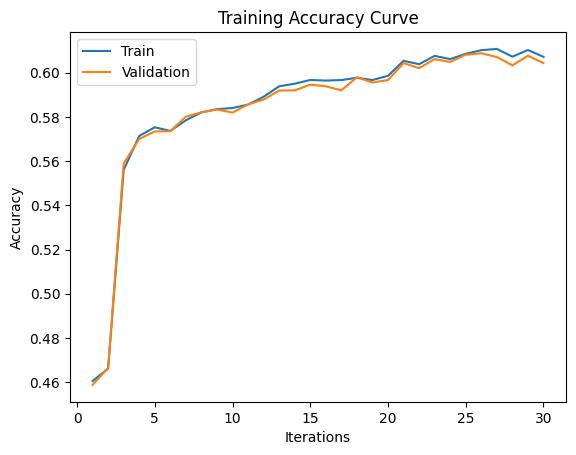

Final Training Accuracy: 0.6072
Final Training Loss: 0.0384
Final Validation Accuracy: 0.6044
Final Validation Loss: 0.0385


In [44]:
upscale_model = UpscaleAutoEncoder()
train(upscale_model, train_data, valid_data, batch_size=32, num_epochs=30, learning_rate=1e-4, plotting=True)

In [47]:
# 5.decrease model complexity
class SimpleAutoEncoder(nn.Module):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()
        self.name = "SimpleAutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 43), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(43, 30),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 43), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(43, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch 1: Train Acc: 0.4563 | Train Loss: 0.1352 | Validation Acc: 0.4547 | Validation Loss: 0.0713
Epoch 2: Train Acc: 0.5029 | Train Loss: 0.0684 | Validation Acc: 0.5034 | Validation Loss: 0.0627
Epoch 3: Train Acc: 0.5352 | Train Loss: 0.0576 | Validation Acc: 0.5392 | Validation Loss: 0.0552
Epoch 4: Train Acc: 0.5561 | Train Loss: 0.0542 | Validation Acc: 0.5593 | Validation Loss: 0.0529
Epoch 5: Train Acc: 0.5686 | Train Loss: 0.0510 | Validation Acc: 0.5693 | Validation Loss: 0.0490
Epoch 6: Train Acc: 0.5718 | Train Loss: 0.0462 | Validation Acc: 0.5701 | Validation Loss: 0.0439
Epoch 7: Train Acc: 0.5824 | Train Loss: 0.0420 | Validation Acc: 0.5809 | Validation Loss: 0.0402
Epoch 8: Train Acc: 0.5911 | Train Loss: 0.0388 | Validation Acc: 0.5885 | Validation Loss: 0.0377
Epoch 9: Train Acc: 0.5983 | Train Loss: 0.0371 | Validation Acc: 0.5965 | Validation Loss: 0.0365
Epoch 10: Train Acc: 0.6009 | Train Loss: 0.0361 | Validation Acc: 0.6001 | Validation Loss: 0.0355
Epoch 11:

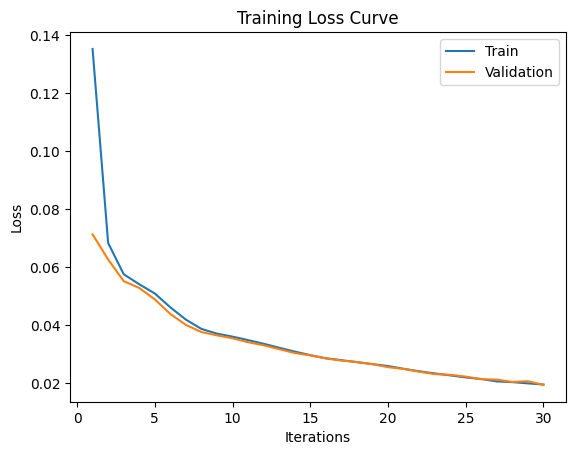

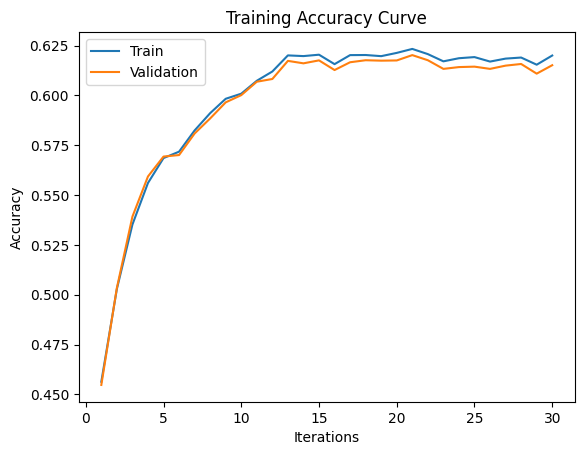

Final Training Accuracy: 0.6200
Final Training Loss: 0.0196
Final Validation Accuracy: 0.6152
Final Validation Loss: 0.0195


In [48]:
simple_model = SimpleAutoEncoder()
train(simple_model, train_data, valid_data, batch_size=32, num_epochs=30, learning_rate=1e-4, plotting=True)

In [49]:
# best performing model for now is 2 original model with batch_size=32
# 6. use that and decrease learning rate
model = AutoEncoder()
train(model, train_data, valid_data, batch_size=32, num_epochs=100, learning_rate=1e-5, plotting=False)

Finish Training
Total time elapsed: 503.46 seconds
Final Training Accuracy: 0.6046
Final Training Loss: 0.0355
Final Validation Accuracy: 0.6036
Final Validation Loss: 0.0353


Epoch 1: Train Acc: 0.5762 | Train Loss: 0.0651 | Validation Acc: 0.5748 | Validation Loss: 0.0415
Epoch 2: Train Acc: 0.6159 | Train Loss: 0.0331 | Validation Acc: 0.6105 | Validation Loss: 0.0287
Epoch 3: Train Acc: 0.6189 | Train Loss: 0.0262 | Validation Acc: 0.6152 | Validation Loss: 0.0248
Epoch 4: Train Acc: 0.6193 | Train Loss: 0.0227 | Validation Acc: 0.6162 | Validation Loss: 0.0215
Epoch 5: Train Acc: 0.6229 | Train Loss: 0.0205 | Validation Acc: 0.6224 | Validation Loss: 0.0198
Epoch 6: Train Acc: 0.6285 | Train Loss: 0.0186 | Validation Acc: 0.6276 | Validation Loss: 0.0178
Epoch 7: Train Acc: 0.6281 | Train Loss: 0.0174 | Validation Acc: 0.6269 | Validation Loss: 0.0167
Epoch 8: Train Acc: 0.6150 | Train Loss: 0.0160 | Validation Acc: 0.6126 | Validation Loss: 0.0165
Epoch 9: Train Acc: 0.6322 | Train Loss: 0.0151 | Validation Acc: 0.6319 | Validation Loss: 0.0157
Epoch 10: Train Acc: 0.6330 | Train Loss: 0.0143 | Validation Acc: 0.6322 | Validation Loss: 0.0145
Epoch 11:

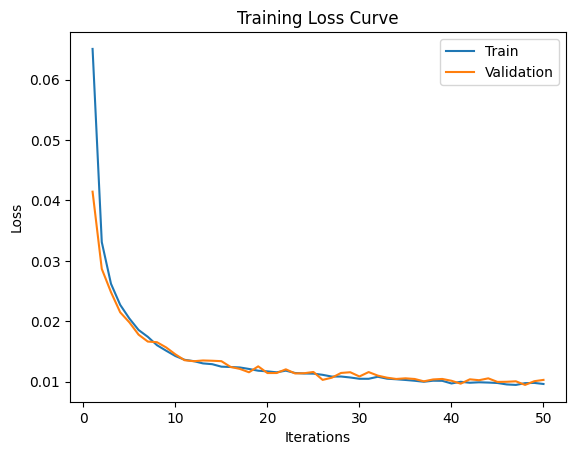

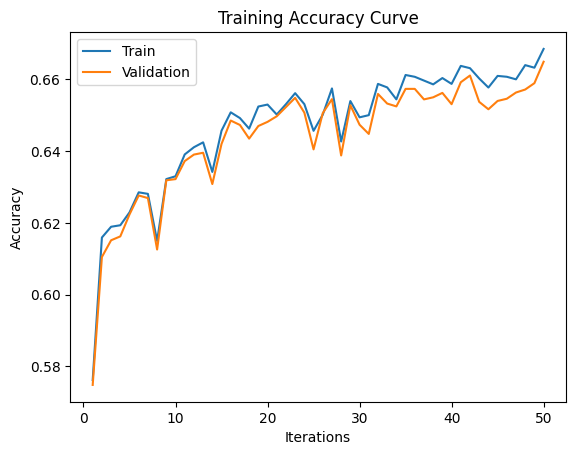

Final Training Accuracy: 0.6685
Final Training Loss: 0.0096
Final Validation Accuracy: 0.6649
Final Validation Loss: 0.0103


In [51]:
# 7. increase learning rate
model = AutoEncoder()
train(model, train_data, valid_data, batch_size=32, num_epochs=50, learning_rate=1e-3, plotting=True)

Epoch 1: Train Acc: 0.5996 | Train Loss: 0.0579 | Validation Acc: 0.6037 | Validation Loss: 0.0354
Epoch 2: Train Acc: 0.6003 | Train Loss: 0.0293 | Validation Acc: 0.5983 | Validation Loss: 0.0250
Epoch 3: Train Acc: 0.6130 | Train Loss: 0.0225 | Validation Acc: 0.6088 | Validation Loss: 0.0205
Epoch 4: Train Acc: 0.6035 | Train Loss: 0.0195 | Validation Acc: 0.6016 | Validation Loss: 0.0192
Epoch 5: Train Acc: 0.6244 | Train Loss: 0.0177 | Validation Acc: 0.6227 | Validation Loss: 0.0167
Epoch 6: Train Acc: 0.6229 | Train Loss: 0.0158 | Validation Acc: 0.6199 | Validation Loss: 0.0156
Epoch 7: Train Acc: 0.6277 | Train Loss: 0.0152 | Validation Acc: 0.6245 | Validation Loss: 0.0144
Epoch 8: Train Acc: 0.6315 | Train Loss: 0.0140 | Validation Acc: 0.6295 | Validation Loss: 0.0144
Epoch 9: Train Acc: 0.6359 | Train Loss: 0.0140 | Validation Acc: 0.6353 | Validation Loss: 0.0134
Epoch 10: Train Acc: 0.6363 | Train Loss: 0.0132 | Validation Acc: 0.6332 | Validation Loss: 0.0137
Epoch 11:

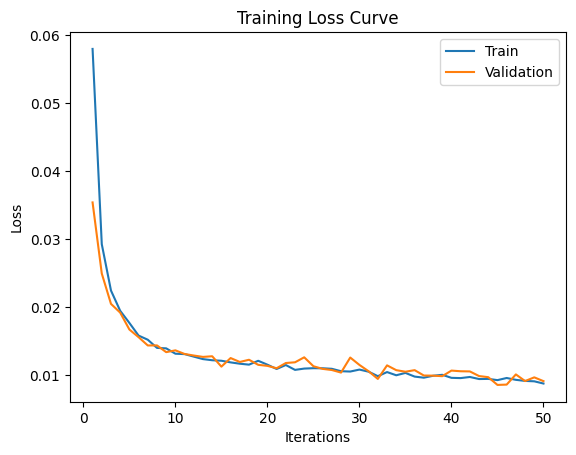

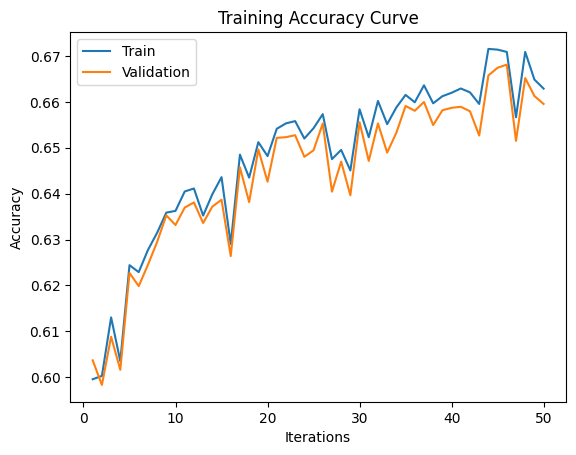

Final Training Accuracy: 0.6629
Final Training Loss: 0.0088
Final Validation Accuracy: 0.6595
Final Validation Loss: 0.0092


In [52]:
# 8. increase batch_size and increase learning rate
model = AutoEncoder()
train(model, train_data, valid_data, batch_size=64, num_epochs=50, learning_rate=3e-3, plotting=True)

In [73]:
# 9.early stopping
model = AutoEncoder()
train(model, train_data, valid_data, batch_size=64, num_epochs=44, learning_rate=3e-3, plotting=False)

Finish Training
Total time elapsed: 164.07 seconds
Final Training Accuracy: 0.7129
Final Training Loss: 0.0087
Final Validation Accuracy: 0.7156
Final Validation Loss: 0.0084


## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [74]:
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
with torch.no_grad():
  test_acc = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.7083604541838432


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [34]:
len(catcols)

6

In [35]:
df_not_missing
import pandas as pd

most_common_values = []
mcv_prob = []

for category in catcols:
  # Find the most frequent category's probability
  most_common_values.append(df_not_missing[category].value_counts().idxmax())
  mcv_prob.append(df_not_missing[category].value_counts(normalize=True).max())

print("Most Common Values: ", most_common_values)
print("probabilities of mcv: ", mcv_prob)
# Average over all features
expected_accuracy = sum(mcv_prob) / len(catcols)

print(f"Expected Test Accuracy of Baseline Model: {expected_accuracy:.4f}")


Most Common Values:  [' Private', ' Married-civ-spouse', ' Prof-specialty', ' HS-grad', ' Husband', ' Male']
probabilities of mcv:  [0.7388501855589557, 0.4667947131974738, 0.1347743993749593, 0.32450029298782473, 0.4135685917051891, 0.6767367667165831]
Expected Test Accuracy of Baseline Model: 0.4592


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**Answwer**: My test acuracy from part(a) which is 0.7084 which is much **better** than 0.4592 from part(b).

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

**Answer**: The first item in the test data is a 32 year-old male who has 9 years of education. From our dataset, it's not hard to see 9 years of education basically implicates high-school graduate. So it is reasonable **easy** for a human to guess this person's education level based on number of years of education.

In [78]:
test_data[0]

array([0.20547946, 0.53333336, 0.        , 0.        , 0.39795917,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        ], dtype=float32)

In [60]:
get_features(test_data[0])

{'work': 'Federal-gov',
 'marriage': 'Never-married',
 'occupation': 'Other-service',
 'edu': 'HS-grad',
 'relationship': 'Own-child',
 'sex': 'Male'}

In [59]:
normalized_cont = test_data[0][:5]

# restore normalization
original_cont = (normalized_cont * (max_values - min_values)) + min_values
print(original_cont)

age        32.000000
yredu       9.000000
capgain     0.000000
caploss     0.000000
workhr     39.999999
dtype: float64


In [87]:
original_df[:10]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [85]:
edu_hidden = zero_out_feature(test_data[:1],"edu")[0]
with torch.no_grad():
  edu_pred = model(torch.from_numpy(edu_hidden)).detach().numpy()
edu_val = get_feature(edu_pred, 'edu')

print(edu_val)

HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [86]:
df_not_missing['edu'].value_counts().idxmax()

' HS-grad'